In [ ]:
# ============================
# Step 1: Unzip Dataset
# ============================
import zipfile
import os

# TODO: Set the correct uploaded ZIP filename
zip_path = 'dataset.zip'  # <-- replace with the exact uploaded filename
extract_path = './dataset'  # folder where you want to extract

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Unzipped to: {os.path.abspath(extract_path)}")
print("Contents:")
print(os.listdir(extract_path))


In [ ]:
# ============================
# Step 2: Split Dataset into Train/Test
# ============================
import shutil, random
SOURCE_DIR = 'dataset'
TARGET_DIR = 'dataset_split'
train_ratio = 0.7
...
print("✅ Dataset split complete!")


In [ ]:
import os, torch
from torch.utils.data import DataLoader
...
show_2x6_grid(train_set, 2, "Train Set Grid")
show_2x6_grid(test_set, 2, "Test Set Grid")


In [ ]:
import torch.nn as nn
from einops import rearrange, repeat, einsum

def pair(t): ...
class PreNorm(nn.Module): ...
class FeedForward(nn.Module): ...
class Attention(nn.Module): ...
class Transformer(nn.Module): ...
class ViT(nn.Module): ...


In [ ]:
model = ViT(image_size=28, patch_size=4, num_classes=6, ...)
optimizer = optim.Adam(model.parameters(), lr=0.003)
print(model)


In [ ]:
def train_epoch(...):
    ...
def evaluate(...):
    ...
for epoch in range(1, N_EPOCHS + 1):
    ...
torch.save(model.state_dict(), 'Student_ID.pth')


In [ ]:
def plot_confusion_matrix(model, ...): ...
def plot_classwise_predictions(model, ...): ...
# 使用時取消註解：
# plot_confusion_matrix(model, test_loader, train_set.classes)
# plot_classwise_predictions(model, test_loader, train_set.classes, 4)


In [2]:
!pip install torchinfo

In [3]:
# ============================================================
#  StudentID_Lab8_Homework.py  (Vision Transformer from scratch)
# ============================================================
#  STEP 0. 套件
import os, zipfile, random, shutil, time, math
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix
from torchinfo import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------[ 參數區 ]---------------------------
zip_path   = '/content/dataset.zip'   # ← 上傳到 Colab 後的路徑
extract_to = './dataset'              # 解壓資料夾
STUDENT_ID = '110123456'              # ← 改成你的學號
TRAIN_RATIO= 0.7
BATCH_SIZE = 64
LR         = 3e-4
EPOCHS     = 30
IMG_SIZE   = 28                       # 影像 Resize 28×28
PATCH      = 4                        # 4×4 patch ⇒ 49 tokens
DIM        = 64                       # token 嵌入維度
DEPTH      = 6                        # Encoder 疊數
HEADS      = 4                        # Multi‑head 數
MLP_DIM    = 128                      # FFN Hidden dim
SEED       = 42
# -------------------------------------------------------------
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ============================================================
#  STEP 1. 解壓資料集
# ============================================================
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path,'r') as zf: zf.extractall(extract_to)
    print('✅ Unzipped!')
else:
    print('✅ Dataset already exists.')

# ============================================================
#  STEP 2. 切 7/3 Train‑Test
# ============================================================
split_root='./dataset_split'
if not os.path.exists(split_root):
    for sp in ['train','test']:
        for cls in os.listdir(extract_to):
            os.makedirs(f'{split_root}/{sp}/{cls}', exist_ok=True)
    for cls in os.listdir(extract_to):
        imgs=os.listdir(f'{extract_to}/{cls}')
        random.shuffle(imgs)
        cut=int(len(imgs)*TRAIN_RATIO)
        for i,im in enumerate(imgs):
            sp='train' if i<cut else 'test'
            shutil.copyfile(f'{extract_to}/{cls}/{im}',
                            f'{split_root}/{sp}/{cls}/{im}')
    print('✅ Dataset split complete!')
else:
    print('✅ Split folder exists.')

# ============================================================
#  STEP 3. Dataloader
# ============================================================
transform=T.Compose([
    T.Resize((IMG_SIZE,IMG_SIZE)),
    T.Grayscale(),
    T.ToTensor(),
    T.Normalize((0.5,),(0.5,))
])
train_set=torchvision.datasets.ImageFolder(f'{split_root}/train',transform)
test_set =torchvision.datasets.ImageFolder(f'{split_root}/test', transform)

train_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True,
                        num_workers=2,pin_memory=True)
test_loader =DataLoader(test_set ,batch_size=BATCH_SIZE,shuffle=False,
                        num_workers=2,pin_memory=True)
print('Classes:', train_set.classes, ' | Train:',len(train_set),
      ' | Test:',len(test_set))

# ============================================================
#  STEP 4. Vision Transformer (from scratch)
# ============================================================
def pair(x): return x if isinstance(x,tuple) else (x,x)

class PreNorm(nn.Module):
    def __init__(self,dim,fn):
        super().__init__(); self.norm=nn.LayerNorm(dim); self.fn=fn
    def forward(self,x,**kw): return x + self.fn(self.norm(x),**kw)

class FeedForward(nn.Module):
    def __init__(self,dim,hidden,drop=0.):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(dim,hidden), nn.GELU(), nn.Dropout(drop),
            nn.Linear(hidden,dim), nn.Dropout(drop))
    def forward(self,x): return self.net(x)

class Attention(nn.Module):
    def __init__(self,dim,heads=8,dim_head=64,drop=0.):
        super().__init__()
        self.heads=heads; inner=dim_head*heads; self.scale=dim_head**-0.5
        self.to_qkv=nn.Linear(dim,inner*3, bias=False)
        self.to_out=nn.Sequential(nn.Linear(inner,dim), nn.Dropout(drop))
        self.drop=nn.Dropout(drop)
    def forward(self,x):
        b,n,_=x.shape
        q,k,v=self.to_qkv(x).chunk(3,dim=-1)          # (b,n,inner)
        q=q.view(b,n,self.heads,-1).transpose(1,2)    # (b,h,n,d)
        k=k.view(b,n,self.heads,-1).transpose(1,2)
        v=v.view(b,n,self.heads,-1).transpose(1,2)
        dots=(q@k.transpose(-1,-2))*self.scale        # (b,h,n,n)
        attn=self.drop(dots.softmax(dim=-1))
        out=(attn@v).transpose(1,2).contiguous().view(b,n,-1)
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self,dim,depth,heads,dim_head,mlp_dim,drop=0.):
        super().__init__()
        self.layers=nn.ModuleList([
            nn.ModuleList([
                PreNorm(dim, Attention(dim,heads,dim_head,drop)),
                PreNorm(dim, FeedForward(dim,mlp_dim,drop))
            ]) for _ in range(depth)])
    def forward(self,x):
        for attn,ff in self.layers: x=ff(attn(x))
        return x

class ViT(nn.Module):
    def __init__(self,*,image_size,patch_size,num_classes,dim,depth,
                 heads,mlp_dim,pool='cls',channels=1,dim_head=64,
                 dropout=0.,emb_dropout=0.):
        super().__init__()
        img_h,img_w=pair(image_size); p_h,p_w=pair(patch_size)
        assert img_h%p_h==img_w%p_w==0
        num_patches=(img_h//p_h)*(img_w//p_w)
        patch_dim=channels*p_h*p_w
        self.patch_size=(p_h,p_w)
        self.to_patch=nn.Unfold(kernel_size=(p_h,p_w),stride=(p_h,p_w))
        self.patch_proj=nn.Linear(patch_dim,dim)
        self.cls_token=nn.Parameter(torch.randn(1,1,dim))
        self.pos_embed=nn.Parameter(torch.randn(1,num_patches+1,dim))
        self.dropout=nn.Dropout(emb_dropout)
        self.transformer=Transformer(dim,depth,heads,dim_head,mlp_dim,dropout)
        self.pool=pool; self.norm=nn.LayerNorm(dim)
        self.mlp_head=nn.Sequential(nn.Linear(dim,mlp_dim),
                                    nn.GELU(),
                                    nn.Dropout(dropout),
                                    nn.Linear(mlp_dim,num_classes))
    def forward(self,img):
        B=img.shape[0]; p_h,p_w=self.patch_size
        x=self.to_patch(img)                  # (B, patch_dim, N)
        x=x.transpose(1,2)                    # (B, N, patch_dim)
        x=self.patch_proj(x)                  # (B, N, dim)
        cls_tok=self.cls_token.expand(B,-1,-1)
        x=torch.cat((cls_tok,x),dim=1)        # (B, N+1, dim)
        x=x+self.pos_embed[:, :x.size(1)]
        x=self.dropout(x)

        x=self.transformer(x)
        x=self.norm(x[:,0] if self.pool=='cls' else x.mean(dim=1))
        return self.mlp_head(x)

# Initialize model & optimizer
model=ViT(image_size=IMG_SIZE,patch_size=PATCH,num_classes=len(train_set.classes),
          dim=DIM,depth=DEPTH,heads=HEADS,mlp_dim=MLP_DIM,channels=1).to(device)
optimizer=optim.Adam(model.parameters(),lr=LR)
criterion =nn.CrossEntropyLoss()

# Model summary (for screenshot a)
print(summary(model, input_size=(BATCH_SIZE,1,IMG_SIZE,IMG_SIZE)))

# ============================================================
#  STEP 5. Train / Evaluate
# ============================================================
def train_epoch(model,loader):
    model.train(); running=0
    for i,(x,y) in enumerate(loader):
        x,y=x.to(device),y.to(device)
        optimizer.zero_grad()
        out=model(x); loss=criterion(out,y)
        loss.backward(); optimizer.step()
        running+=loss.item()
        if i%100==0: print(f'  Batch {i:03d} | loss {loss.item():.4f}')
    return running/len(loader)

@torch.no_grad()
def evaluate(model,loader):
    model.eval(); loss_tot=0; correct=0; N=len(loader.dataset)
    for x,y in loader:
        x,y=x.to(device),y.to(device)
        out=model(x); loss_tot+=criterion(out,y).item()
        correct+=(out.argmax(1)==y).sum().item()
    acc=100*correct/N
    print(f'  ▶ Test loss {loss_tot/len(loader):.4f} | acc {acc:.2f}%')
    return loss_tot/len(loader),acc

start=time.time()
for ep in range(1,EPOCHS+1):
    print(f'Epoch {ep}/{EPOCHS}')
    tr_loss=train_epoch(model,train_loader)
    te_loss,te_acc=evaluate(model,test_loader)
end=time.time()
print(f'⏱ Total time {end-start:.1f}s')

torch.save(model.state_dict(), f'{STUDENT_ID}_Lab8_Homework.pth')
print('✅ Weights saved.')

# ============================================================
#  STEP 6. 混淆矩陣 & 示範預測 (for screenshot c & d)
# ============================================================
@torch.no_grad()
def plot_confusion_matrix(model,loader,class_names):
    y_true,y_pred=[],[]
    model.eval()
    for x,y in loader:
        y_true.extend(y.numpy())
        y_pred.extend(model(x.to(device)).argmax(1).cpu().numpy())
    cm=confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
                xticklabels=class_names,yticklabels=class_names)
    plt.xlabel('Pred'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.show()

@torch.no_grad()
def plot_classwise_predictions(model,loader,class_names,k=4):
    buckets={c:[] for c in range(len(class_names))}
    model.eval()
    for x,y in loader:
        preds=model(x.to(device)).argmax(1).cpu()
        for img,t,p in zip(x,y,preds):
            if len(buckets[t.item()])<k:
                buckets[t.item()].append((img,p.item()==t.item(),p.item()))
        if all(len(v)==k for v in buckets.values()): break
    rows=k; cols=len(class_names)
    plt.figure(figsize=(2*cols,2*rows))
    for c in range(cols):
        for r in range(rows):
            img,ok,pred=buckets[c][r]
            ax=plt.subplot(rows,cols,r*cols+c+1)
            ax.imshow(img.squeeze()*0.5+0.5,cmap='gray')
            ax.set_title(f'T:{class_names[c]}\nP:{class_names[pred]}',
                         color='g' if ok else 'r',fontsize=8)
            ax.axis('off')
    plt.suptitle('Test Predictions (green = ✓, red = ✗)')
    plt.tight_layout(); plt.show()

# === 執行下列兩行 → 取圖貼進報告 ===
# plot_confusion_matrix(model, test_loader, train_set.classes)
# plot_classwise_predictions(model, test_loader, train_set.classes, k=4)


✅ Unzipped!
✅ Dataset split complete!
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']  | Train: 1260  | Test: 540
Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [64, 6]                   3,264
├─Unfold: 1-1                                      [64, 16, 49]              --
├─Linear: 1-2                                      [64, 49, 64]              1,088
├─Dropout: 1-3                                     [64, 50, 64]              --
├─Transformer: 1-4                                 [64, 50, 64]              --
│    └─ModuleList: 2-1                             --                        --
│    │    └─ModuleList: 3-1                        --                        82,432
│    │    └─ModuleList: 3-2                        --                        82,432
│    │    └─ModuleList: 3-3                        --                        82,432
│    │    └─Modu

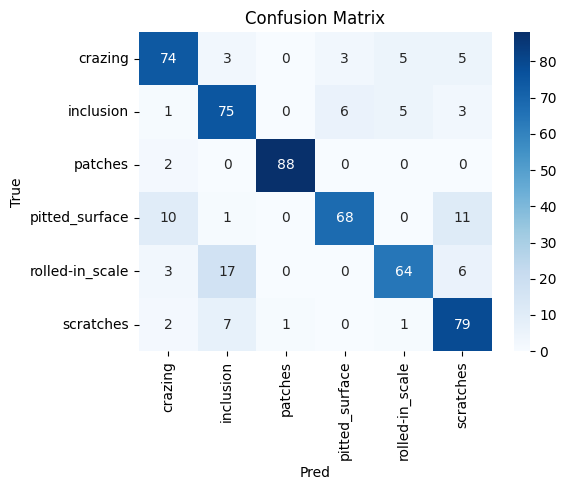

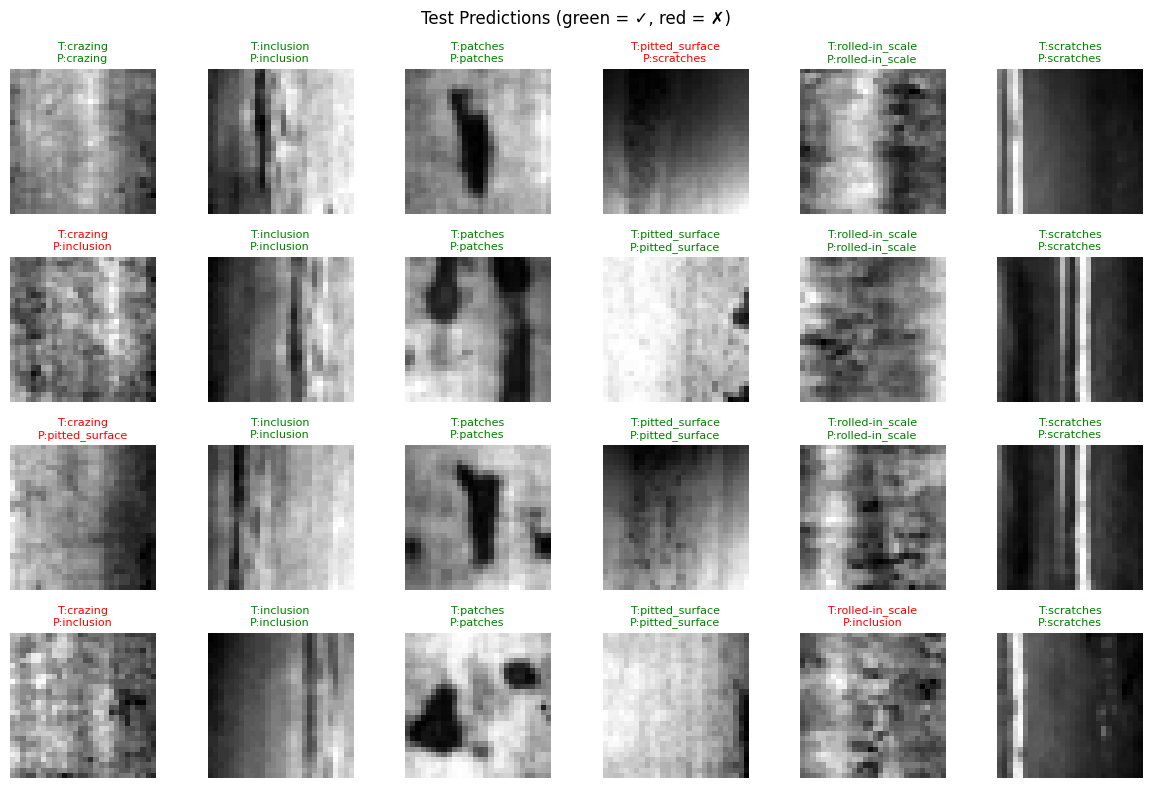

In [4]:
plot_confusion_matrix(model, test_loader, train_set.classes)
plot_classwise_predictions(model, test_loader, train_set.classes, k=4)